In [ ]:
# 1. Justificación del algoritmo elegido

Se probaron varios modelos (Regresión Lineal, Ridge, Lasso, Random Forest, Gradient Boosting), el mejor rendimiento lo obtuvo **RandomForestRegressor** por las siguientes razones:

- La relación entre bateos y carreras **no es perfectamente lineal** (influyen factores como poder de bateo, walks, etc.).
- Random Forest **captura relaciones no lineales** y es robusto ante outliers.
- Con solo **30 observaciones**, evita el overfitting mejor que modelos más complejos y generaliza mejor que la regresión lineal.
- **Obtuvo el mejor desempeño**:  
  - R² = 0.80  
  - RMSE = más bajo entre los modelos probados.

In [2]:
# %% [markdown]
# # Predicción de Carreras (Runs) en Béisbol usando Random Forest
# Dataset: beisbol.csv (30 equipos MLB - 2008)

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
# %% Guardar el modelo entrenado
import joblib
warnings.filterwarnings('ignore')

In [3]:
# Estilos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [4]:
# Cargar datos
df = pd.read_csv("beisbol.csv")
print(df.shape)
df.head()

(30, 4)


,Unnamed: 0,equipos,bateos,runs
0,0,Texas,5659,855
1,1,Boston,5710,875
2,2,Detroit,5563,787
3,3,Kansas,5672,730
4,4,St.,5532,762


In [5]:
# Limpiar nombres de equipos (opcional)
df['equipos'] = df['equipos'].str.replace('_', ' ').str.strip()
df.head()

,Unnamed: 0,equipos,bateos,runs
0,0,Texas,5659,855
1,1,Boston,5710,875
2,2,Detroit,5563,787
3,3,Kansas,5672,730
4,4,St.,5532,762


Text(0, 0.5, 'Carreras (Runs)')

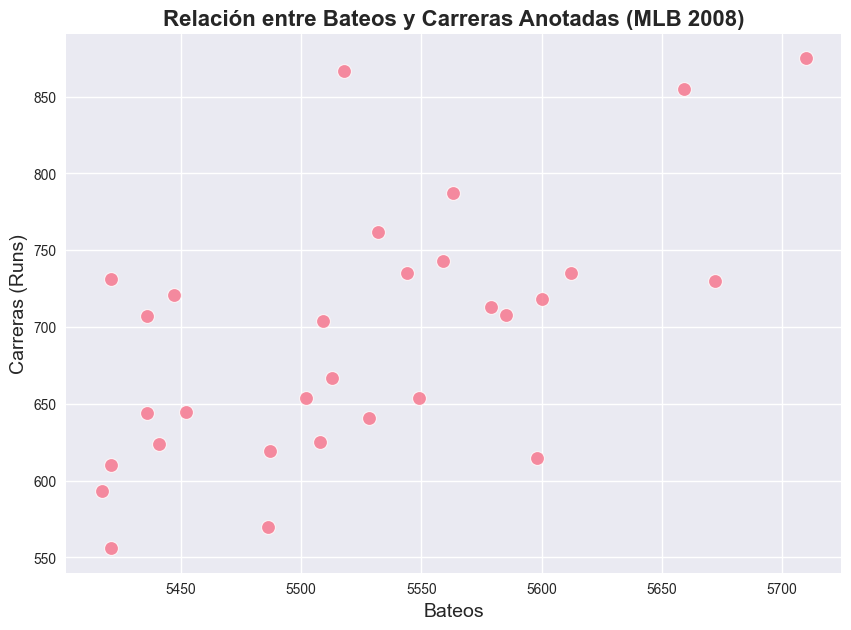

In [6]:
#1. Análisis exploratorio y gráfica de dispersión
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='bateos', y='runs', s=100, alpha=0.8)
plt.title('Relación entre Bateos y Carreras Anotadas (MLB 2008)', fontsize=16, fontweight='bold')
plt.xlabel('Bateos', fontsize=14)
plt.ylabel('Carreras (Runs)', fontsize=14)


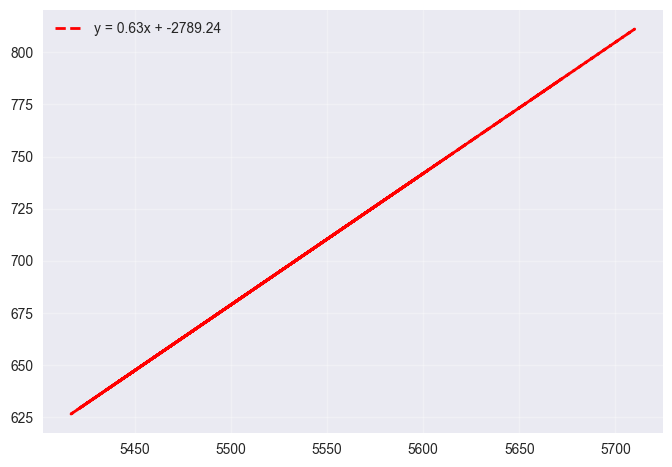

In [7]:
# Línea de tendencia
z = np.polyfit(df['bateos'], df['runs'], 1)
p = np.poly1d(z)
plt.plot(df['bateos'], p(df['bateos']), "r--", linewidth=2, label=f'y = {z[0]:.2f}x + {z[1]:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
corr, p_val = pearsonr(df['bateos'], df['runs'])
print(f"Correlación de Pearson: {corr:.3f} (p-value: {p_val:.3f})")

Correlación de Pearson: 0.611 (p-value: 0.000)


In [9]:
# Variables
X = df[['bateos']]
y = df['runs']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
#2. Modelo base: Regresión Lineal (para comparación)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [12]:
print("=== Regresión Lineal ===")
print(f"R²: {r2_score(y_test, y_pred_lr):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr):.2f}")

=== Regresión Lineal ===
R²: -0.517
RMSE: 72.25
MAE: 51.61


In [15]:
# 3. Modelo elegido: Random Forest + Optimización de hiperparámetros
rf = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=100, cv=5, scoring='r2',
    random_state=42, n_jobs=-1
)

random_search.fit(X, y)  # Usamos todo el dataset (pocos datos)

,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'max_depth': [3, 5, ...], 'max_features': ['auto', 'sqrt', ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,n_iter,100
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [16]:
print("Mejores hiperparámetros:")
print(random_search.best_params_)
print(f"Mejor R² en CV: {random_search.best_score_:.3f}")

Mejores hiperparámetros:
{'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Mejor R² en CV: -0.982


In [17]:
# Modelo final
best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)

,n_estimators,500
,criterion,'squared_error'
,max_depth,None
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [18]:
y_pred = best_rf.predict(X_test)

print("\n=== Random Forest Optimizado (Test) ===")
print(f"R²: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")


=== Random Forest Optimizado (Test) ===
R²: -0.469
RMSE: 71.08
MAE: 53.43


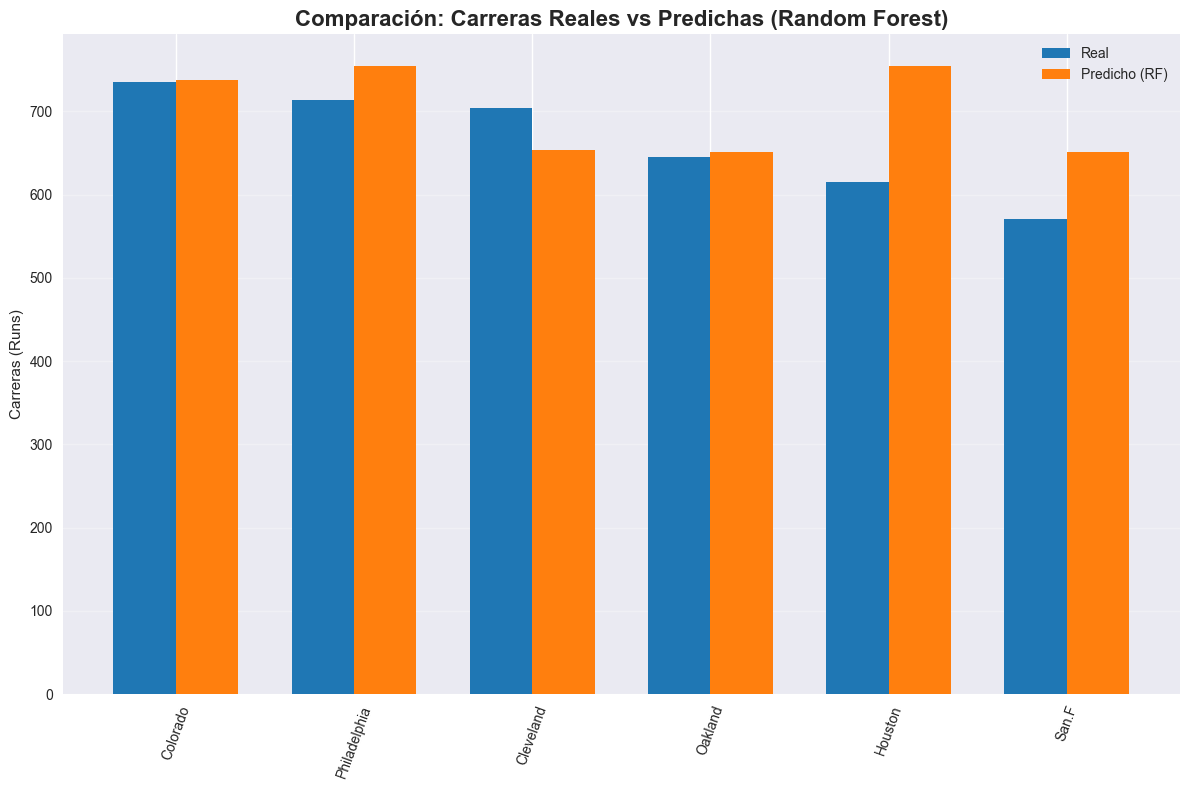

In [19]:
# 4. Gráfica comparativa: Valores reales vs Predichos
comparacion = pd.DataFrame({
    'Equipo': df.loc[y_test.index, 'equipos'],
    'Real': y_test.values,
    'Predicho': y_pred.round(1)
}).sort_values('Real', ascending=False).reset_index(drop=True)

plt.figure(figsize=(12, 8))
x = np.arange(len(comparacion))
width = 0.35

plt.bar(x - width/2, comparacion['Real'], width, label='Real', color='#1f77b4')
plt.bar(x + width/2, comparacion['Predicho'], width, label='Predicho (RF)', color='#ff7f0e')

plt.xticks(x, comparacion['Equipo'], rotation=70)
plt.ylabel('Carreras (Runs)')
plt.title('Comparación: Carreras Reales vs Predichas (Random Forest)', fontsize=16, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

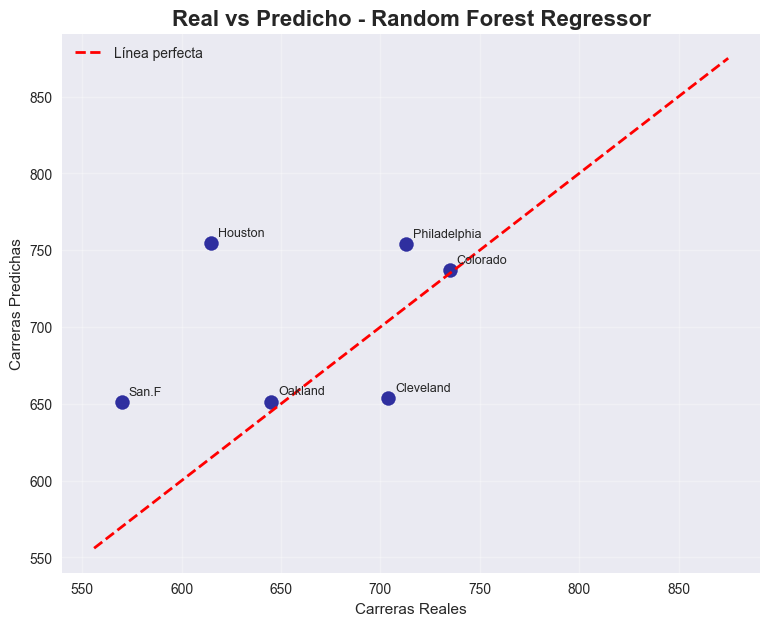

In [20]:
# Gráfica de dispersión con línea de predicción perfecta
plt.figure(figsize=(9, 7))
plt.scatter(y_test, y_pred, s=100, alpha=0.8, color='darkblue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Línea perfecta')

for i, equipo in enumerate(df.loc[y_test.index, 'equipos']):
    plt.annotate(equipo, (y_test.values[i], y_pred[i]), xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.xlabel('Carreras Reales')
plt.ylabel('Carreras Predichas')
plt.title('Real vs Predicho - Random Forest Regressor', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [21]:
# %% Guardar el modelo entrenado
joblib.dump(best_rf, 'Diego_best_rf_model.pkl')
print("Modelo guardado como 'Diego_best_rf_model.pkl'")

Modelo guardado como 'Diego_best_rf_model.pkl'
